#  Karlo

pros - conceptually more "stable" outputs
cons - small output size (256x256)

suggestion - apparently can swap out the VAE to the SD unclip 2.1 one, which shouldn't be extremely hard to do.

In [12]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableUnCLIPImg2ImgPipeline, UnCLIPImageVariationPipeline, ImagePipelineOutput

import inspect
from typing import List, Optional, Union

import PIL.Image
import torch
from torch.nn import functional as F
from transformers import (
    CLIPImageProcessor,
    CLIPTextModelWithProjection,
    CLIPTokenizer,
    CLIPVisionModelWithProjection,
)

In [13]:
class customUnClipPipeline(UnCLIPImageVariationPipeline):
    def _encode_prompt(self, prompt,  device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt = "",):
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # get prompt text embeddings
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        text_mask = text_inputs.attention_mask.bool().to(device)
        text_encoder_output = self.text_encoder(text_input_ids.to(device))

        prompt_embeds = text_encoder_output.text_embeds
        text_encoder_hidden_states = text_encoder_output.last_hidden_state

        prompt_embeds = prompt_embeds.repeat_interleave(num_images_per_prompt, dim=0)
        text_encoder_hidden_states = text_encoder_hidden_states.repeat_interleave(num_images_per_prompt, dim=0)
        text_mask = text_mask.repeat_interleave(num_images_per_prompt, dim=0)

        if do_classifier_free_guidance:
            uncond_tokens = [negative_prompt] * batch_size

            max_length = text_input_ids.shape[-1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )
            uncond_text_mask = uncond_input.attention_mask.bool().to(device)
            negative_prompt_embeds_text_encoder_output = self.text_encoder(uncond_input.input_ids.to(device))

            negative_prompt_embeds = negative_prompt_embeds_text_encoder_output.text_embeds
            uncond_text_encoder_hidden_states = negative_prompt_embeds_text_encoder_output.last_hidden_state

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method

            seq_len = negative_prompt_embeds.shape[1]
            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len)

            seq_len = uncond_text_encoder_hidden_states.shape[1]
            uncond_text_encoder_hidden_states = uncond_text_encoder_hidden_states.repeat(1, num_images_per_prompt, 1)
            uncond_text_encoder_hidden_states = uncond_text_encoder_hidden_states.view(
                batch_size * num_images_per_prompt, seq_len, -1
            )
            uncond_text_mask = uncond_text_mask.repeat_interleave(num_images_per_prompt, dim=0)

            # done duplicates

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
            text_encoder_hidden_states = torch.cat([uncond_text_encoder_hidden_states, text_encoder_hidden_states])

            text_mask = torch.cat([uncond_text_mask, text_mask])

        return prompt_embeds, text_encoder_hidden_states, text_mask
    
    @torch.no_grad()
    def __call__(
        self,
        text_input: str = "",
        negative_prompt: str = "",
        image: Optional[Union[PIL.Image.Image, List[PIL.Image.Image], torch.Tensor]] = None,
        num_images_per_prompt: int = 1,
        decoder_num_inference_steps: int = 25,
        super_res_num_inference_steps: int = 7,
        generator: Optional[torch.Generator] = None,
        decoder_latents: Optional[torch.Tensor] = None,
        super_res_latents: Optional[torch.Tensor] = None,
        image_embeddings: Optional[torch.Tensor] = None,
        decoder_guidance_scale: float = 8.0,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ):
        """
        The call function to the pipeline for generation.

        Args:
            image (`PIL.Image.Image` or `List[PIL.Image.Image]` or `torch.Tensor`):
                `Image` or tensor representing an image batch to be used as the starting point. If you provide a
                tensor, it needs to be compatible with the [`CLIPImageProcessor`]
                [configuration](https://huggingface.co/fusing/karlo-image-variations-diffusers/blob/main/feature_extractor/preprocessor_config.json).
                Can be left as `None` only when `image_embeddings` are passed.
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            decoder_num_inference_steps (`int`, *optional*, defaults to 25):
                The number of denoising steps for the decoder. More denoising steps usually lead to a higher quality
                image at the expense of slower inference.
            super_res_num_inference_steps (`int`, *optional*, defaults to 7):
                The number of denoising steps for super resolution. More denoising steps usually lead to a higher
                quality image at the expense of slower inference.
            generator (`torch.Generator`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            decoder_latents (`torch.Tensor` of shape (batch size, channels, height, width), *optional*):
                Pre-generated noisy latents to be used as inputs for the decoder.
            super_res_latents (`torch.Tensor` of shape (batch size, channels, super res height, super res width), *optional*):
                Pre-generated noisy latents to be used as inputs for the decoder.
            decoder_guidance_scale (`float`, *optional*, defaults to 4.0):
                A higher guidance scale value encourages the model to generate images closely linked to the text
                `prompt` at the expense of lower image quality. Guidance scale is enabled when `guidance_scale > 1`.
            image_embeddings (`torch.Tensor`, *optional*):
                Pre-defined image embeddings that can be derived from the image encoder. Pre-defined image embeddings
                can be passed for tasks like image interpolations. `image` can be left as `None`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.ImagePipelineOutput`] instead of a plain tuple.

        Returns:
            [`~pipelines.ImagePipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.ImagePipelineOutput`] is returned, otherwise a `tuple` is
                returned where the first element is a list with the generated images.
        """
        if image is not None:
            if isinstance(image, PIL.Image.Image):
                batch_size = 1
            elif isinstance(image, list):
                batch_size = len(image)
            else:
                batch_size = image.shape[0]
        else:
            batch_size = image_embeddings.shape[0]

        prompt = [text_input] * batch_size

        device = self._execution_device

        batch_size = batch_size * num_images_per_prompt

        do_classifier_free_guidance = decoder_guidance_scale > 1.0

        prompt_embeds, text_encoder_hidden_states, text_mask = self._encode_prompt(
            prompt,  device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt ,
        )

        image_embeddings = self._encode_image(image, device, num_images_per_prompt, image_embeddings)

        # decoder
        text_encoder_hidden_states, additive_clip_time_embeddings = self.text_proj(
            image_embeddings=image_embeddings,
            prompt_embeds=prompt_embeds,
            text_encoder_hidden_states=text_encoder_hidden_states,
            do_classifier_free_guidance=do_classifier_free_guidance,
        )

        if device.type == "mps":
            # HACK: MPS: There is a panic when padding bool tensors,
            # so cast to int tensor for the pad and back to bool afterwards
            text_mask = text_mask.type(torch.int)
            decoder_text_mask = F.pad(text_mask, (self.text_proj.clip_extra_context_tokens, 0), value=1)
            decoder_text_mask = decoder_text_mask.type(torch.bool)
        else:
            decoder_text_mask = F.pad(text_mask, (self.text_proj.clip_extra_context_tokens, 0), value=True)

        self.decoder_scheduler.set_timesteps(decoder_num_inference_steps, device=device)
        decoder_timesteps_tensor = self.decoder_scheduler.timesteps

        num_channels_latents = self.decoder.config.in_channels
        height = self.decoder.config.sample_size
        width = self.decoder.config.sample_size

        if decoder_latents is None:
            decoder_latents = self.prepare_latents(
                (batch_size, num_channels_latents, height, width),
                text_encoder_hidden_states.dtype,
                device,
                generator,
                decoder_latents,
                self.decoder_scheduler,
            )

        for i, t in enumerate(self.progress_bar(decoder_timesteps_tensor)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([decoder_latents] * 2) if do_classifier_free_guidance else decoder_latents

            noise_pred = self.decoder(
                sample=latent_model_input,
                timestep=t,
                encoder_hidden_states=text_encoder_hidden_states,
                class_labels=additive_clip_time_embeddings,
                attention_mask=decoder_text_mask,
            ).sample

            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred_uncond, _ = noise_pred_uncond.split(latent_model_input.shape[1], dim=1)
                noise_pred_text, predicted_variance = noise_pred_text.split(latent_model_input.shape[1], dim=1)
                noise_pred = noise_pred_uncond + decoder_guidance_scale * (noise_pred_text - noise_pred_uncond)
                noise_pred = torch.cat([noise_pred, predicted_variance], dim=1)

            if i + 1 == decoder_timesteps_tensor.shape[0]:
                prev_timestep = None
            else:
                prev_timestep = decoder_timesteps_tensor[i + 1]

            # compute the previous noisy sample x_t -> x_t-1
            decoder_latents = self.decoder_scheduler.step(
                noise_pred, t, decoder_latents, prev_timestep=prev_timestep, generator=generator
            ).prev_sample

        decoder_latents = decoder_latents.clamp(-1, 1)

        image_small = decoder_latents

        # done decoder

        # super res

        self.super_res_scheduler.set_timesteps(super_res_num_inference_steps, device=device)
        super_res_timesteps_tensor = self.super_res_scheduler.timesteps

        channels = self.super_res_first.config.in_channels // 2
        height = self.super_res_first.config.sample_size
        width = self.super_res_first.config.sample_size

        if super_res_latents is None:
            super_res_latents = self.prepare_latents(
                (batch_size, channels, height, width),
                image_small.dtype,
                device,
                generator,
                super_res_latents,
                self.super_res_scheduler,
            )

        if device.type == "mps":
            # MPS does not support many interpolations
            image_upscaled = F.interpolate(image_small, size=[height, width])
        else:
            interpolate_antialias = {}
            if "antialias" in inspect.signature(F.interpolate).parameters:
                interpolate_antialias["antialias"] = True

            image_upscaled = F.interpolate(
                image_small, size=[height, width], mode="bicubic", align_corners=False, **interpolate_antialias
            )

        for i, t in enumerate(self.progress_bar(super_res_timesteps_tensor)):
            # no classifier free guidance

            if i == super_res_timesteps_tensor.shape[0] - 1:
                unet = self.super_res_last
            else:
                unet = self.super_res_first

            latent_model_input = torch.cat([super_res_latents, image_upscaled], dim=1)

            noise_pred = unet(
                sample=latent_model_input,
                timestep=t,
            ).sample

            if i + 1 == super_res_timesteps_tensor.shape[0]:
                prev_timestep = None
            else:
                prev_timestep = super_res_timesteps_tensor[i + 1]

            # compute the previous noisy sample x_t -> x_t-1
            super_res_latents = self.super_res_scheduler.step(
                noise_pred, t, super_res_latents, prev_timestep=prev_timestep, generator=generator
            ).prev_sample

        image = super_res_latents

        # done super res
        self.maybe_free_model_hooks()

        # post processing

        image = image * 0.5 + 0.5
        image = image.clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)
        

In [14]:
### ADDITIONAL PIPELINE CODE FOR KARLO
pipe = customUnClipPipeline.from_pretrained("kakaobrain/karlo-v1-alpha-image-variations", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_model_cpu_offload()


Loading pipeline components...:   0%|                                                                | 0/10 [00:00<?, ?it/s]An error occurred while trying to fetch /home/hew7/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snapshots/4573828a41f333df688b1111b04add3d9f548331/super_res_last: Error no file named diffusion_pytorch_model.safetensors found in directory /home/hew7/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snapshots/4573828a41f333df688b1111b04add3d9f548331/super_res_last.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  10%|█████▌                                                  | 1/10 [00:10<01:34, 10.46s/it]An error occurred while trying to fetch /home/hew7/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snapshots/4573828a41f333df688b1111b04add3d9f548331/text_proj: Error no file named diffusion_pytorch_model.safetensor

In [15]:
# func for getting tensor embeddings from cand image

def load_image(image_dir):
    image = Image.open(image_dir).convert("RGB")
    return image

def load_img_from_URL(URL):
    response = requests.get(URL)
    init_image = Image.open(BytesIO(response.content)).convert("RGB")
    return init_image

def embed_img(input_image):
    tokens = pipe.feature_extractor(input_image)
    img_model = pipe.image_encoder.to('cpu')
    with torch.no_grad():
        embeds = img_model(torch.tensor(tokens.pixel_values[0]).unsqueeze(0))
        
    return embeds.image_embeds.to('cpu')


def localimg_2_embed(image_dir):
    embeds = embed_img(load_image(image_dir))
    return embeds

def URLimg_2_embed(URL):
    embeds = embed_img(load_img_from_URL(URL))
    return embeds


In [16]:
# random generator for softmaxxed outputs

def random_probdist(num_cands):
    random_numbers = torch.randn(num_cands)
    softmax_output = torch.nn.functional.softmax(random_numbers, dim=0).reshape((num_cands,1))
    return softmax_output

In [17]:
def scalesum_candtensors(list_scale, cand_tensors):
    '''
    quick note - just make sure your list_scale is the same length as ur cand_tensors, and also adds up to 1
    '''
    assert sum(list_scale) == 1, f"you didn't input a valid probability distribution - make sure your scales add up to 1, currently it adds up to {sum(list_scale)}"
    assert len(list_scale) == len(cand_tensors), f"your scale list is not the same length as your list of candidate tensors. len list = {len(list_scale)}, len cand tensors = {len(cand_tensors)}"

    scaled = torch.tensor(list_scale), cand_tensors
    output = scaled.sum(dim=0)
    return output
    

def random_candtensor(cand_tensors):
    scaled = random_probdist(len(cand_tensors)) * cand_tensors
    output = scaled.sum(dim=0)
    return output

In [18]:
# for displaying images
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# simpsons char demo

I'm only making this one because I'm lazy and just need characters I can load via URL for a colab demo

In [19]:
homer_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/b/bd/Homer_Simpson.png/revision/latest?cb=20121120224917')
marge_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/d/d5/Marge_Simpson.jpg/revision/latest?cb=20110417084805')
bart_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/1/11/Bart_Simpson.jpg/revision/latest?cb=20120129085633')
lisa_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/e/ec/Lisa_Simpson.png/revision/latest?cb=20121223225143')
maggie_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/9/9d/Maggie_Simpson.png/revision/latest?cb=20121223225248')
grandpa_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/5/5d/Grandpa_Abe_Simpson.png/revision/latest?cb=20121222032244')
patty_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/f/f8/Patty_Bouvier.png/revision/latest?cb=20130414140225')
selma_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/b/ba/Selma_Bouvier.png/revision/latest?cb=20130414140253')
ned_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/d/d2/NedFlanders.png/revision/latest?cb=20130321014614')
moe_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/f/f8/MoeSyzlak.png/revision/latest?cb=20130315001058')
chief_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/1/10/ChiefClancyWiggum.png/revision/latest?cb=20130313114954')

In [20]:
simpsons_cand_tensors = torch.cat([homer_tensor,
                                marge_tensor,
                                bart_tensor,
                                lisa_tensor,
                                maggie_tensor,
                                grandpa_tensor,
                                patty_tensor,
                                selma_tensor,
                                ned_tensor,
                                moe_tensor,
                                chief_tensor,
                                   ], dim=0)

In [21]:
simpsons_randomised_input = random_candtensor(simpsons_cand_tensors).unsqueeze(0).half()

In [22]:
output = pipe(image_embeddings=simpsons_randomised_input, num_images_per_prompt=2, text_input = 'high quality output, correct eyes, cartoon eyes with small dots as pupils, no glitches, 4k, ', negative_prompt = "low quality, glitchy, nightmare, horrifying")

100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.04s/it]


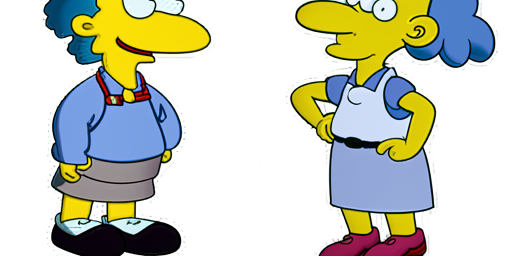

In [23]:
image_grid(output.images, 1,2)

# flux 2 generated examples (based on 11 pictures generated from descs of personas)

In [40]:
#caniddate tensors for flux images

chaos_clicker_tensor = localimg_2_embed('flux2-cand-imgs/chaos-clicker-flux-2.jpg').to('cpu')
content_consr_tensor = localimg_2_embed('flux2-cand-imgs/content-connoisseur-flux-2.jpg').to('cpu')
digital_daydrmr_tensor = localimg_2_embed('flux2-cand-imgs/digital-daydreamer-flux-2.jpg').to('cpu')
eco_explorer_tensor = localimg_2_embed('flux2-cand-imgs/eco-explorer-flux-2.jpg').to('cpu')
fandom_fox_tensor = localimg_2_embed('flux2-cand-imgs/fandom-fox-flux-2.jpg').to('cpu')
meme_maven_tensor = localimg_2_embed('flux2-cand-imgs/meme-maven-flux-2.jpg').to('cpu')
news_nerd_tensor = localimg_2_embed('flux2-cand-imgs/news-nerd-flux-2.jpg').to('cpu')
nostalgic_navgtr_tensor = localimg_2_embed('flux2-cand-imgs/nostalgic-navigator-flux-2.jpg').to('cpu')
scrollseeker_tensor = localimg_2_embed('flux2-cand-imgs/scrollseeker-flux-2.jpg').to('cpu')
social_synth_tensor = localimg_2_embed('flux2-cand-imgs/social-synthesiser-flux-2.jpg').to('cpu')
trend_tracker_tensor = localimg_2_embed('flux2-cand-imgs/trend-tracker-flux-2.jpg').to('cpu')

In [41]:
flux_cand_tensors = torch.cat([chaos_clicker_tensor,
                content_consr_tensor,
                digital_daydrmr_tensor,
                eco_explorer_tensor,
                fandom_fox_tensor,
                meme_maven_tensor ,
                news_nerd_tensor ,
                nostalgic_navgtr_tensor ,
                scrollseeker_tensor ,
                social_synth_tensor ,
                trend_tracker_tensor ,
               ], dim=0)

In [42]:
flux_randomised_input = random_candtensor(flux_cand_tensors).unsqueeze(0).half()

In [43]:
output = pipe(image_embeddings=flux_randomised_input, num_images_per_prompt=2, text_input = 'high quality output, correct eyes, cartoon eyes with small dots as pupils, no glitches, 4k, ', negative_prompt = "low quality, glitchy, nightmare, horrifying")

100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.10it/s]


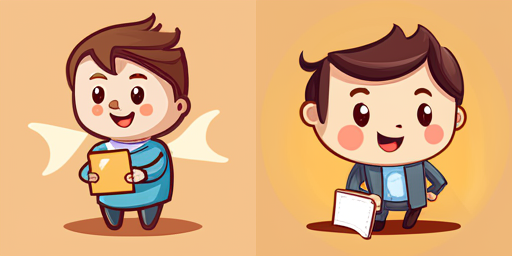

In [44]:
image_grid(output.images, 1,2)


# examples based on arthur imgs

We might have a bit more success with more stylistically consistent images, so I figured I'd just pick characters all from the same tv show.

In [45]:
arthur_tensor = localimg_2_embed('arthur-imgs/arthur.png').to('cpu')
baby_tensor = localimg_2_embed('arthur-imgs/baby.png').to('cpu')
binky_tensor = localimg_2_embed('arthur-imgs/binky.png').to('cpu')
buster_tensor = localimg_2_embed('arthur-imgs/buster.png').to('cpu')
dw_tensor = localimg_2_embed('arthur-imgs/dw.png').to('cpu')
fern_tensor = localimg_2_embed('arthur-imgs/fern.png').to('cpu')
francine_tensor = localimg_2_embed('arthur-imgs/francine.png').to('cpu')
muffy_tensor = localimg_2_embed('arthur-imgs/muffy.png').to('cpu')
pal_tensor = localimg_2_embed('arthur-imgs/pal.png').to('cpu')
ratburn_tensor = localimg_2_embed('arthur-imgs/ratburn.png').to('cpu')
thebrain_tensor = localimg_2_embed('arthur-imgs/thebrain.png').to('cpu')

In [46]:
arthur_cand_tensors = torch.cat([arthur_tensor,
                            baby_tensor,
                            binky_tensor,
                            buster_tensor,
                            dw_tensor ,
                            fern_tensor,
                            francine_tensor,
                            muffy_tensor,
                            pal_tensor,
                            ratburn_tensor,
                            thebrain_tensor,], dim=0)

In [47]:
arthur_randomised_input = random_candtensor(arthur_cand_tensors).unsqueeze(0).half()

In [48]:
output = pipe(image_embeddings=arthur_randomised_input, num_images_per_prompt=2)

100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.07it/s]


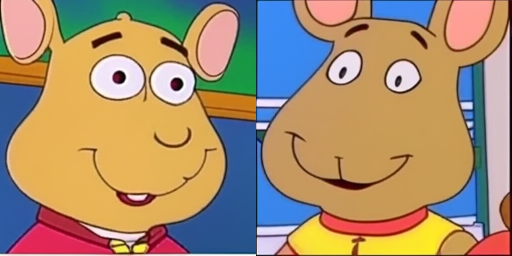

In [49]:
image_grid(output.images, 1,2)

# examples based on my images

In [24]:
chaosclicker_willtensor = localimg_2_embed('willpaint-imgs/chaosclicker-willpaint.png').to('cpu')
contentcnsr_willtensor = localimg_2_embed('willpaint-imgs/contentconnoisseur-willpaint.png').to('cpu')
digdaydrmr_willtensor = localimg_2_embed('willpaint-imgs/digitaldaydreamer-willpaint.png').to('cpu')
ecoexplr_willtensor = localimg_2_embed('willpaint-imgs/ecoexplorer-willpaint.png').to('cpu')
fandomfox_willtensor = localimg_2_embed('willpaint-imgs/fandomfox-willpaint.png').to('cpu')
mememaven_willtensor = localimg_2_embed('willpaint-imgs/mememaven-willpaint.png').to('cpu')
newsnerd_willtensor = localimg_2_embed('willpaint-imgs/newnerd-willpaint.png').to('cpu')
nostalgicnvgtr_willtensor = localimg_2_embed('willpaint-imgs/nostalgicnavigator-willpaint.png').to('cpu')
scrollseeker_willtensor = localimg_2_embed('willpaint-imgs/scrollseeker-willpaint.png').to('cpu')
trendtracker_willtensor = localimg_2_embed('willpaint-imgs/trendtracker-willpaint.png').to('cpu')

In [25]:
will_cand_tensors = torch.cat([chaosclicker_willtensor,
                                contentcnsr_willtensor ,
                                digdaydrmr_willtensor,
                                ecoexplr_willtensor,
                                fandomfox_willtensor,
                                mememaven_willtensor,
                                newsnerd_willtensor,
                                nostalgicnvgtr_willtensor,
                                scrollseeker_willtensor,
                                trendtracker_willtensor,], dim=0)

In [93]:
will_randomised_input = random_candtensor(will_cand_tensors).unsqueeze(0).half()

In [96]:
output = pipe(image_embeddings=will_randomised_input, num_images_per_prompt=2)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.11it/s]


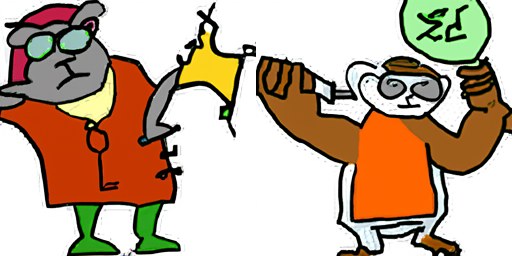

In [97]:
image_grid(output.images, 1,2)

# examples based on dan's images

In [35]:
scrollseeker_dantensor = localimg_2_embed('dan-imgs/1 - scroll seeker.png').to('cpu')
mememaven_dantensor = localimg_2_embed('dan-imgs/2 - meme maven.png').to('cpu')
fandomfox_dantensor = localimg_2_embed('dan-imgs/3 - fandom fox.png').to('cpu')
nostalgicnvgtr_dantensor = localimg_2_embed('dan-imgs/4 - nostalgic navigator.png').to('cpu')
socialsnthsr_dantensor = localimg_2_embed('dan-imgs/5 social synthesiser.png').to('cpu')
chaosclicker_dantensor = localimg_2_embed('dan-imgs/6 - chaos clicker.png').to('cpu')
ecoexplorer_dantensor = localimg_2_embed('dan-imgs/7 - eco explorer.png').to('cpu')
newsnerd_dantensor = localimg_2_embed('dan-imgs/8 - news nerd.png').to('cpu')
trendtracker_dantensor = localimg_2_embed('dan-imgs/9 - trend tracker.png').to('cpu')
digitlddrmr_dantensor = localimg_2_embed('dan-imgs/10 - digital daydreamer.png').to('cpu')

In [36]:
dan_cand_tensors = torch.cat([scrollseeker_dantensor,
                                mememaven_dantensor,
                                fandomfox_dantensor,
                                nostalgicnvgtr_dantensor,
                                socialsnthsr_dantensor,
                                chaosclicker_dantensor,
                                ecoexplorer_dantensor,
                                newsnerd_dantensor,
                                trendtracker_dantensor,
                                digitlddrmr_dantensor,], dim=0)

In [51]:
dan_randomised_input = random_candtensor(dan_cand_tensors).unsqueeze(0).half()

In [78]:
output = pipe(image_embeddings=dan_randomised_input, num_images_per_prompt=2)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.08it/s]


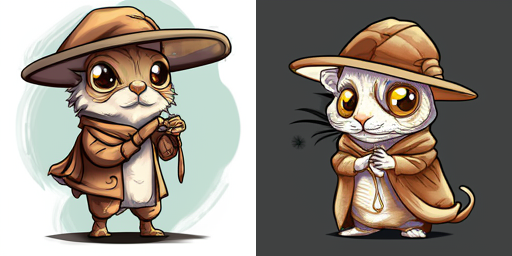

In [79]:
image_grid(output.images, 1,2)

# upressing the results

Looks like we can just use a stable diffusion upscaler on the outputs - we don't even have to swap out the VAE

In [23]:
from diffusers import StableDiffusionUpscalePipeline

In [24]:
model_id = "stabilityai/stable-diffusion-x4-upscaler"
upres_pipeline = StableDiffusionUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
upres_pipeline = upres_pipeline.to("cuda")
upres_pipeline.enable_model_cpu_offload()

Loading pipeline components...: 100%|█████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.24it/s]


In [92]:
upscaled_image = upres_pipeline(prompt = 'high quality, no artifacts, 4k,', image=output.images[0]).images[0]

100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:36<00:00,  2.05it/s]


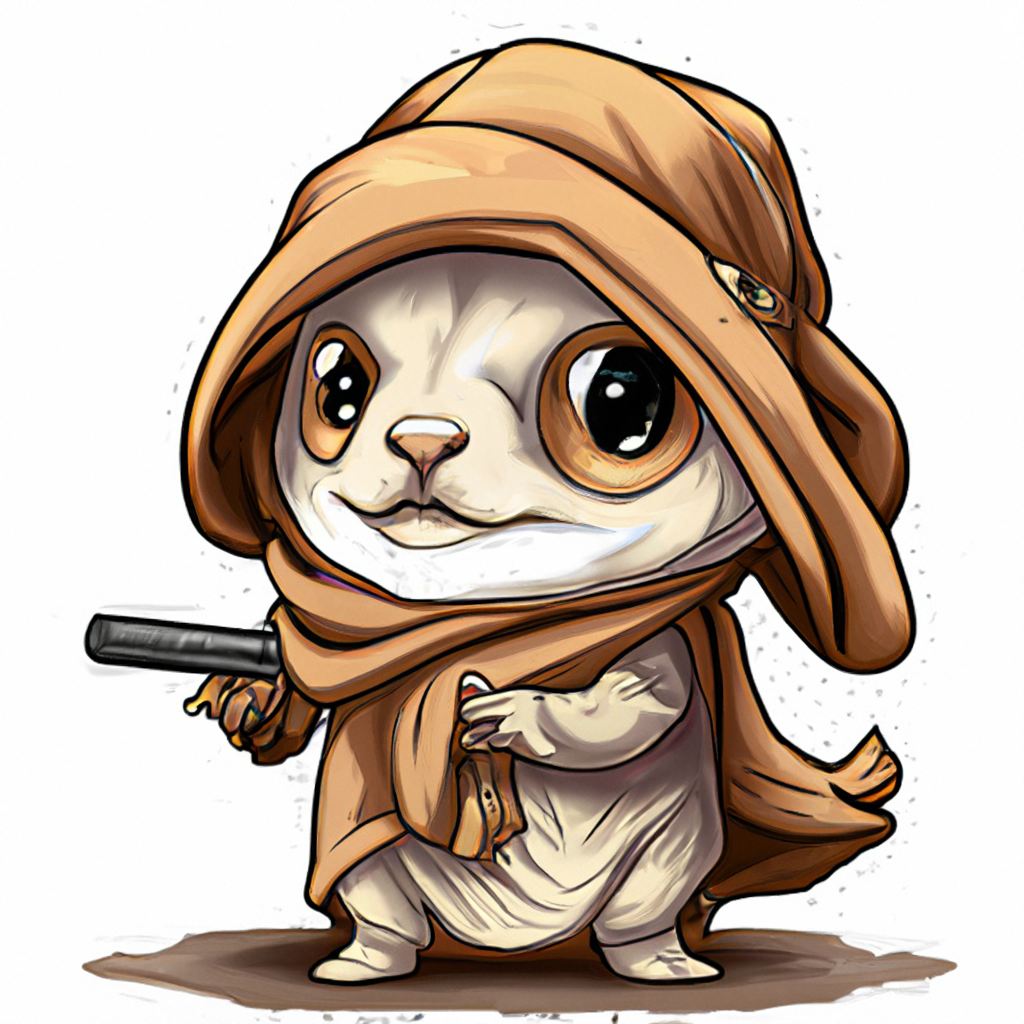

In [93]:
upscaled_image